In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# von Schuckmann et al. 2020

Here we process the von Schuckmann et al. 2020 heat content data.

In [3]:
import glob
import os
import os.path
import warnings

import iris
import iris.pandas
import numpy as np
import numpy.testing as npt
import pandas as pd
import tqdm.autonotebook as tqdman
from netcdf_scm.iris_cube_wrappers import ScmCube
from netcdf_scm.utils import get_scm_cube_time_axis_in_calendar
from scmdata import ScmRun
from scmdata.run import run_append

import utils.rcmip
from utils.io import ensure_dir_exists

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

/data/ubuntu-znicholls/miniconda3/envs/rcmip-phase-2/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>

In [4]:
DATA_PROTOCOL = os.path.join(
    "../../data/processed/submission-template/rcmip-data-submission-template.xlsx"
)

<IPython.core.display.Javascript object>

In [5]:
protocol_variables = pd.read_excel(
    DATA_PROTOCOL, sheet_name="variable_definitions", engine="openpyxl"
)
protocol_variables.head()

idx                    Category  \
0    1  Atmospheric Concentrations   
1    2  Atmospheric Concentrations   
2    3  Atmospheric Concentrations   
3    4  Atmospheric Concentrations   
4    5  Atmospheric Concentrations   

                                        Variable Unit  \
0                 Atmospheric Concentrations|CH4  ppb   
1                 Atmospheric Concentrations|CO2  ppm   
2             Atmospheric Concentrations|F-Gases  ppm   
3         Atmospheric Concentrations|F-Gases|HFC  ppm   
4  Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt   

                                          Definition  Tier  Unnamed: 6  \
0                  atmospheric concentrations of CH4     1         NaN   
1                  atmospheric concentrations of CO2     1         NaN   
2  equivalent species atmospheric concentrations ...     3         NaN   
3  equivalent species atmospheric concentrations ...     3         NaN   
4               atmospheric concentrations of HFC125     2         NaN   

   Unnamed: 7  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

<IPython.core.display.Javascript object>

In [6]:
OUTPUT_FILE = os.path.join(
    "..",
    "..",
    "data",
    "interim",
    "vonschuckmann_2020",
    "vonschuckmann_2020_rcmip.nc",
)
ensure_dir_exists(OUTPUT_FILE)

<IPython.core.display.Javascript object>

In [7]:
OUTPUT_FILE_ARS = os.path.join(
    "..",
    "..",
    "data",
    "interim",
    "vonschuckmann_2020",
    "vonschuckmann_2020_assessed_ranges.csv",
)
ensure_dir_exists(OUTPUT_FILE_ARS)

<IPython.core.display.Javascript object>

In [8]:
VON_SCHUCKMANN_DATA_PATH = os.path.join("..", "..", "data", "raw", "vonschuckmann_2020")

<IPython.core.display.Javascript object>

In [9]:
vonschuckmann_files = glob.glob(
    os.path.expanduser(os.path.join(VON_SCHUCKMANN_DATA_PATH, "*.nc"))
)
assert len(vonschuckmann_files) == 1
vonschuckmann_files

['../../data/raw/vonschuckmann_2020/GCOS_all_heat_content_1960-2018_ZJ_v22062020.nc']

<IPython.core.display.Javascript object>

In [10]:
tmp = iris.load([f for f in vonschuckmann_files])
tmp

[<iris 'Cube' of Ocean Heat Content (below 2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble mean of Area Averaged Ocean Heat Content Anomaly (0-700m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble Standard Deviation of Area Averaged Ocean Heat Content Anomaly (0-700m) / (ZJ) (time: 59)>,
<iris 'Cube' of Atmospheric Heat Content / (ZJ) (time: 59)>,
<iris 'Cube' of Ground Heat Content / (ZJ) (time: 59)>,
<iris 'Cube' of Atmospheric Heat Content Uncertainty / (ZJ) (time: 59)>,
<iris 'Cube' of Ground Heat Content Uncertainty / (ZJ) (time: 59)>,
<iris 'Cube' of Cryosphere Heat Content Uncertainty / (ZJ) (time: 59)>,
<iris 'Cube' of Atmospheric heat content coverage factor / (1) (time: 59)>,
<iris 'Cube' of Ensemble Standard Deviation of Area Averaged Ocean Heat Content Anomaly (0-300m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ocean Heat Content Uncertainty (below 2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble Standard Deviation of Area Averaged Ocean Heat Content Anomaly (0-2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Cryosphere Heat Content / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble Standard Deviation of Area Averaged Ocean Heat Content Anomaly (700-2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble mean of Area Averaged Ocean Heat Content Anomaly (0-2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble mean of Area Averaged Ocean Heat Content Anomaly (700-2000m) / (ZJ) (time: 59)>,
<iris 'Cube' of Ensemble mean of Area Averaged Ocean Heat Content Anomaly (0-300m) / (ZJ) (time: 59)>]

<IPython.core.display.Javascript object>

In [11]:
raw_cubes = tmp
data = []
standard_names = []
source_names = []
units = []

for i, cube in enumerate(raw_cubes):
    helper = ScmCube()
    helper.cube = cube
    time_ax_cube, _ = helper._get_openscmdata_time_axis_and_calendar(
        {"World": helper}, out_calendar=cube.coord("time").units.calendar
    )
    if i == 0:
        time_ax = time_ax_cube
    else:
        assert (time_ax == time_ax_cube).all()

    data.append(cube.data)
    standard_names.append(cube.name())
    source_names.append(cube.var_name)
    units.append(str(cube.units))

time_ax

Index([1960-06-30 00:00:00, 1961-06-30 00:00:00, 1962-06-30 00:00:00,
       1963-06-30 00:00:00, 1964-06-30 00:00:00, 1965-06-30 00:00:00,
       1966-06-30 00:00:00, 1967-06-30 00:00:00, 1968-06-30 00:00:00,
       1969-06-30 00:00:00, 1970-06-30 00:00:00, 1971-06-30 00:00:00,
       1972-06-30 00:00:00, 1973-06-30 00:00:00, 1974-06-30 00:00:00,
       1975-06-30 00:00:00, 1976-06-30 00:00:00, 1977-06-30 00:00:00,
       1978-06-30 00:00:00, 1979-06-30 00:00:00, 1980-06-30 00:00:00,
       1981-06-30 00:00:00, 1982-06-30 00:00:00, 1983-06-30 00:00:00,
       1984-06-30 00:00:00, 1985-06-30 00:00:00, 1986-06-30 00:00:00,
       1987-06-30 00:00:00, 1988-06-30 00:00:00, 1989-06-30 00:00:00,
       1990-06-30 00:00:00, 1991-06-30 00:00:00, 1992-06-30 00:00:00,
       1993-06-30 00:00:00, 1994-06-30 00:00:00, 1995-06-30 00:00:00,
       1996-06-30 00:00:00, 1997-06-30 00:00:00, 1998-06-30 00:00:00,
       1999-06-30 00:00:00, 2000-06-30 00:00:00, 2001-06-30 00:00:00,
       2002-06-30 00

<IPython.core.display.Javascript object>

In [12]:
source_names

['ohc_below_2000m',
 'ohc_0-700m',
 'ohc_0-700m_uncertainty',
 'atmospheric_heat_content',
 'ground_heat_content',
 'atmospheric_heat_content_uncertainty',
 'ground_heat_content_uncertainty',
 'energy_cryosphere_uncertainty',
 'atmospheric_heat_content_coverage_factor',
 'ohc_0-300m_uncertainty',
 'ohc_below_2000m_uncertainty',
 'ohc_0-2000m_uncertainty',
 'energy_cryosphere',
 'ohc_700-2000m_uncertainty',
 'ohc_0-2000m',
 'ohc_700-2000m',
 'ohc_0-300m']

<IPython.core.display.Javascript object>

In [13]:
name_conversion = {
    "ohc_0-300m": "Heat Content|Ocean|0-300m",
    "ohc_0-300m_uncertainty": "Heat Content|Ocean|0-300m std",
    "ohc_0-700m": "Heat Content|Ocean|0-700m",
    "ohc_0-700m_uncertainty": "Heat Content|Ocean|0-700m std",
    "ohc_0-2000m": "Heat Content|Ocean|0-2000m",
    "ohc_0-2000m_uncertainty": "Heat Content|Ocean|0-2000m std",
    "ohc_below_2000m": "Heat Content|Ocean|Below 2000m",
    "ohc_below_2000m_uncertainty": "Heat Content|Ocean|Below 2000m std",
    "ohc_700-2000m": "Heat Content|Ocean|700-2000m",
    "ohc_700-2000m_uncertainty": "Heat Content|Ocean|700-2000m std",
    "energy_cryosphere": "Heat Content|Ice",
    "energy_cryosphere_uncertainty": "Heat Content|Ice std",
    "ground_heat_content": "Heat Content|Land",
    "ground_heat_content_uncertainty": "Heat Content|Land std",
    "atmospheric_heat_content": "Heat Content|Atmosphere",
    "atmospheric_heat_content_uncertainty": "Heat Content|Atmosphere std",
    "atmospheric_heat_content_coverage_factor": "not used",
}

<IPython.core.display.Javascript object>

In [14]:
var_names = [name_conversion[v] for v in source_names]
var_names

['Heat Content|Ocean|Below 2000m',
 'Heat Content|Ocean|0-700m',
 'Heat Content|Ocean|0-700m std',
 'Heat Content|Atmosphere',
 'Heat Content|Land',
 'Heat Content|Atmosphere std',
 'Heat Content|Land std',
 'Heat Content|Ice std',
 'not used',
 'Heat Content|Ocean|0-300m std',
 'Heat Content|Ocean|Below 2000m std',
 'Heat Content|Ocean|0-2000m std',
 'Heat Content|Ice',
 'Heat Content|Ocean|700-2000m std',
 'Heat Content|Ocean|0-2000m',
 'Heat Content|Ocean|700-2000m',
 'Heat Content|Ocean|0-300m']

<IPython.core.display.Javascript object>

In [15]:
db = ScmRun(
    data=np.vstack(data).T,
    index=time_ax,
    columns={
        "scenario": "historical",
        "model": "not_applicable",
        "region": "World",
        "unit": units,
        "source": "vonshuckmann_et_al_2020",
        "variable_standard_name": standard_names,
        "variable_source_name": source_names,
        "variable": var_names,
    },
)
db.timeseries()

time                                                                                                                                                                                          1960-06-30  \
model          region scenario   source                  unit variable                           variable_source_name                     variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|Below 2000m     ohc_below_2000m                          Ocean Heat Content (below 2000m)                      0.000000   
                                                              Heat Content|Ocean|0-700m          ohc_0-700m                               Ensemble mean of Area Averaged Ocean Heat Conte...    0.000000   
                                                              Heat Content|Ocean|0-700m std      ohc_0-700m_uncertainty                   Ensemble Standard Deviation of Area Averaged Oc...   11.065992   
                                                              Heat Content|Atmosphere            atmospheric_heat_content                 Atmospheric Heat Content                              0.000000   
                                                              Heat Content|Land                  ground_heat_content                      Ground Heat Content                                   0.000000   
                                                              Heat Content|Atmosphere std        atmospheric_heat_content_uncertainty     Atmospheric Heat Content Uncertainty                  0.590709   
                                                              Heat Content|Land std              ground_heat_content_uncertainty          Ground Heat Content Uncertainty                       0.000000   
                                                              Heat Content|Ice std               energy_cryosphere_uncertainty            Cryosphere Heat Content Uncertainty                   0.000000   
                                                         1    not used                           atmospheric_heat_content_coverage_factor Atmospheric heat content coverage factor              3.000000   
                                                         ZJ   Heat Content|Ocean|0-300m std      ohc_0-300m_uncertainty                   Ensemble Standard Deviation of Area Averaged Oc...    8.827065   
                                                              Heat Content|Ocean|Below 2000m std ohc_below_2000m_uncertainty              Ocean Heat Content Uncertainty (below 2000m)          7.410000   
                                                              Heat Content|Ocean|0-2000m std     ohc_0-2000m_uncertainty                  Ensemble Standard Deviation of Area Averaged Oc...   21.220945   
                                                              Heat Content|Ice                   energy_cryosphere                        Cryosphere Heat Content                               0.000000   
                                                              Heat Content|Ocean|700-2000m std   ohc_700-2000m_uncertainty                Ensemble Standard Deviation of Area Averaged Oc...   13.155790   
                                                              Heat Content|Ocean|0-2000m         ohc_0-2000m                              Ensemble mean of Area Averaged Ocean Heat Conte...    0.000000   
                                                              Heat Content|Ocean|700-2000m       ohc_700-2000m                            Ensemble mean of Area Averaged Ocean Heat Conte...    0.000000   
                                                              Heat Content|Ocean|0-300m          ohc_0-300m                               Ensemble mean of Area Averaged Ocean Heat Conte...    0.000000   

time                                                                                                                       

<IPython.core.display.Javascript object>

In [16]:
db_spread = db.filter(variable="*std")
db_spread.get_unique_meta("variable")

['Heat Content|Ocean|0-700m std',
 'Heat Content|Atmosphere std',
 'Heat Content|Land std',
 'Heat Content|Ice std',
 'Heat Content|Ocean|0-300m std',
 'Heat Content|Ocean|Below 2000m std',
 'Heat Content|Ocean|0-2000m std',
 'Heat Content|Ocean|700-2000m std']

<IPython.core.display.Javascript object>

In [17]:
db = db.filter(
    variable=["not used", "*std"],
    keep=False,
)
db.get_unique_meta("variable")

['Heat Content|Ocean|Below 2000m',
 'Heat Content|Ocean|0-700m',
 'Heat Content|Atmosphere',
 'Heat Content|Land',
 'Heat Content|Ice',
 'Heat Content|Ocean|0-2000m',
 'Heat Content|Ocean|700-2000m',
 'Heat Content|Ocean|0-300m']

<IPython.core.display.Javascript object>

In [18]:
db.filter(variable="Heat*")

<scmdata.ScmRun (timeseries: 8, timepoints: 59)>
Time:
	Start: 1960-06-30T00:00:00
	End: 2018-06-30T00:00:00
Meta:
	             model region    scenario                   source unit  \
	0   not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	1   not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	3   not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	4   not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	12  not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	14  not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	15  not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	16  not_applicable  World  historical  vonshuckmann_et_al_2020   ZJ   
	
	                          variable      variable_source_name  \
	0   Heat Content|Ocean|Below 2000m           ohc_below_2000m   
	1        Heat Content|Ocean|0-700m                ohc_0-700m   
	3          Heat Content|Atmosphere  atm

<IPython.core.display.Javascript object>

In [19]:
db = db.convert_unit("ZJ", variable="Heat*").relative_to_ref_period_mean(
    year=range(1960, 1991)
)
db.timeseries()

time                                                                                                                                                                                                                            1960-06-30  \
model          reference_period_end_year reference_period_start_year region scenario   source                  unit variable                       variable_source_name     variable_standard_name                                           
not_applicable 1990                      1960                        World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|Below 2000m ohc_below_2000m          Ocean Heat Content (below 2000m)                      0.000000   
                                                                                                                    Heat Content|Ocean|0-700m      ohc_0-700m               Ensemble mean of Area Averaged Ocean Heat Conte...  -17.178552   
                                                                                                                    Heat Content|Atmosphere        atmospheric_heat_content Atmospheric Heat Content                              0.089233   
                                                                                                                    Heat Content|Land              ground_heat_content      Ground Heat Content                                  -3.678265   
                                                                                                                    Heat Content|Ice               energy_cryosphere        Cryosphere Heat Content                              -0.758097   
                                                                                                                    Heat Content|Ocean|0-2000m     ohc_0-2000m              Ensemble mean of Area Averaged Ocean Heat Conte...  -31.167813   
                                                                                                                    Heat Content|Ocean|700-2000m   ohc_700-2000m            Ensemble mean of Area Averaged Ocean Heat Conte...  -12.341073   
                                                                                                                    Heat Content|Ocean|0-300m      ohc_0-300m               Ensemble mean of Area Averaged Ocean Heat Conte...  -10.643581   

time                                                                                                                                                                                                                            1961-06-30  \
model          reference_period_end_year reference_period_start_year region scenario   source                  unit variable                       variable_source_name     variable_standard_name                                           
not_applicable 1990                      1960                        World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|Below 2000m ohc_below_2000m          Ocean Heat Content (below 2000m)                      0.000000   
                                                                                                                    Heat Content|Ocean|0-700m      ohc_0-700m               Ensemble mean of Area Averaged Ocean Heat Conte...   -8.947837   
                                                                                                                    Heat Content|Atmosphere        atmospheric_heat_content Atmospheric Heat Content                              0.092450   
                                                                                                                    Heat Content|Land              ground_heat_content      Ground Heat Content                                  -3.519981   
                                                                                                                    Heat Content|Ice               energy_cryosphere        Cryosphere Heat Con

<IPython.core.display.Javascript object>

In [20]:
heat_uptake = db.timeseries().diff(axis=1).dropna(axis=1, how="all").reset_index()
heat_uptake["variable"] = heat_uptake["variable"].apply(
    lambda x: x.replace("Heat Content", "Heat Uptake")
)
heat_uptake["unit"] = heat_uptake["unit"].apply(lambda x: "{} / yr".format(x))
heat_uptake = heat_uptake.drop(
    ["variable_standard_name", "variable_source_name"], axis="columns"
)
heat_uptake

time           model  reference_period_end_year  reference_period_start_year  \
0     not_applicable                       1990                         1960   
1     not_applicable                       1990                         1960   
2     not_applicable                       1990                         1960   
3     not_applicable                       1990                         1960   
4     not_applicable                       1990                         1960   
5     not_applicable                       1990                         1960   
6     not_applicable                       1990                         1960   
7     not_applicable                       1990                         1960   

time region    scenario                   source     unit  \
0     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
1     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
2     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
3     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
4     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
5     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
6     World  historical  vonshuckmann_et_al_2020  ZJ / yr   
7     World  historical  vonshuckmann_et_al_2020  ZJ / yr   

time                       variable  1961-06-30 00:00:00  1962-06-30 00:00:00  \
0     Heat Uptake|Ocean|Below 2000m             0.000000             0.000000   
1          Heat Uptake|Ocean|0-700m             8.230716            21.329993   
2            Heat Uptake|Atmosphere             0.003217            -0.863496   
3                  Heat Uptake|Land             0.158284             0.160808   
4                   Heat Uptake|Ice            -0.162765            -0.006301   
5         Heat Uptake|Ocean|0-2000m            13.002721            11.847241   
6       Heat Uptake|Ocean|700-2000m             5.302998             1.969672   
7          Heat Uptake|Ocean|0-300m             9.225903            15.984581   

time  ...  2009-06-30 00:00:00  2010-06-30 00:00:00  2011-06-30 00:00:00  \
0     ...             1.150000             1.150000             1.150002   
1     ...             8.011322            -4.036652             5.078033   
2     ...             1.483380             1.745983            -2.441222   
3     ...             0.570528             0.579224             0.587917   
4     ...             0.596577             0.963480             0.722489   
5     ...            10.916550            -1.328934             7.359802   
6     ...             2.161972             3.076118             2.890213   
7     ...             9.830490            -2.816971             3.349754   

time  2012-06-30 00:00:00  2013-06-30 00:00:00  2014-06-30 00:00:00  \
0                1.150000             1.150000             1.150000   
1                2.769257            13.384003             6.500320   
2                0.514161             0.776883             0.207910   
3                0.596615             0.605309             0.614004   
4                0.471741             0.130170             0.123680   
5                8.187424            21.800064            14.053696   
6                5.550949             8.112541             6.473419   
7                1.816582             7.272766             2.313820   

time  2015-06-30 00:00:00  2016-06-30 00:00:00  2017-06-30 00:00:00  \
0                1.150000             1.150002             1.150000   
1               10.787231            -5.512375            15.259583   
2                1.114656             1.423210            -1.014902   
3                0.622700             0.631395             0.640091   
4                0.350980             0.870080             0.854340   
5               14.764343            -7.031769            20.191437   
6                2.861084             0.518417             5.424232   
7                8.540871            -2.691383             9.229111   

time  2018-06-30 00:00:00  
0     

<IPython.core.display.Javascript object>

In [21]:
db = db.append(heat_uptake).timeseries()
db = ScmRun(db.droplevel(["variable_standard_name", "variable_source_name"]))
db.timeseries()

time                                                                                                                                                   1960-06-30  \
model          reference_period_end_year reference_period_start_year region scenario   source                  unit    variable                                     
not_applicable 1990                      1960                        World  historical vonshuckmann_et_al_2020 ZJ      Heat Content|Ocean|Below 2000m    0.000000   
                                                                                                                       Heat Content|Ocean|0-700m       -17.178552   
                                                                                                                       Heat Content|Atmosphere           0.089233   
                                                                                                                       Heat Content|Land                -3.678265   
                                                                                                                       Heat Content|Ice                 -0.758097   
                                                                                                                       Heat Content|Ocean|0-2000m      -31.167813   
                                                                                                                       Heat Content|Ocean|700-2000m    -12.341073   
                                                                                                                       Heat Content|Ocean|0-300m       -10.643581   
                                                                                                               ZJ / yr Heat Uptake|Ocean|Below 2000m          NaN   
                                                                                                                       Heat Uptake|Ocean|0-700m               NaN   
                                                                                                                       Heat Uptake|Atmosphere                 NaN   
                                                                                                                       Heat Uptake|Land                       NaN   
                                                                                                                       Heat Uptake|Ice                        NaN   
                                                                                                                       Heat Uptake|Ocean|0-2000m              NaN   
                                                                                                                       Heat Uptake|Ocean|700-2000m            NaN   
                                                                                                                       Heat Uptake|Ocean|0-300m               NaN   

time                                                                                                                                                   1961-06-30  \
model          reference_period_end_year reference_period_start_year region scenario   source                  unit    variable                                     
not_applicable 1990                      1960                        World  historical vonshuckmann_et_al_2020 ZJ      Heat Content|Ocean|Below 2000m    0.000000   
                                                                                                                       Heat Content|Ocean|0-700m        -8.947837   
                                                                                                                       Heat Content|Atmosphere           0.092450   
                                                                                                                       Heat Content|Land                -3.519981   
                                       

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='ZJ / yr'>

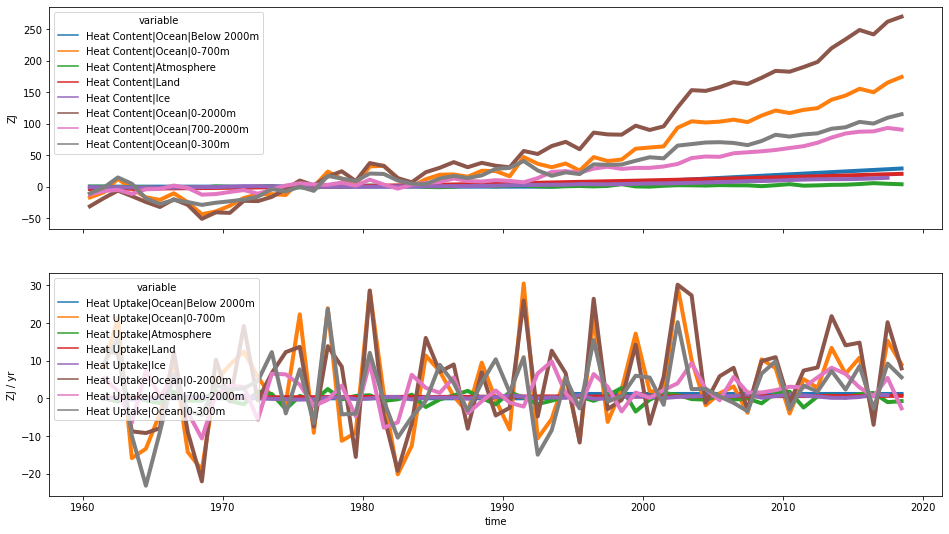

<IPython.core.display.Javascript object>

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9), sharex=True)
db.filter(variable="Heat Content*").lineplot(
    hue="variable", estimator=None, linewidth=4, ax=axes[0]
)
db.filter(variable="Heat Uptake*").lineplot(
    hue="variable", estimator=None, linewidth=4, ax=axes[1]
)

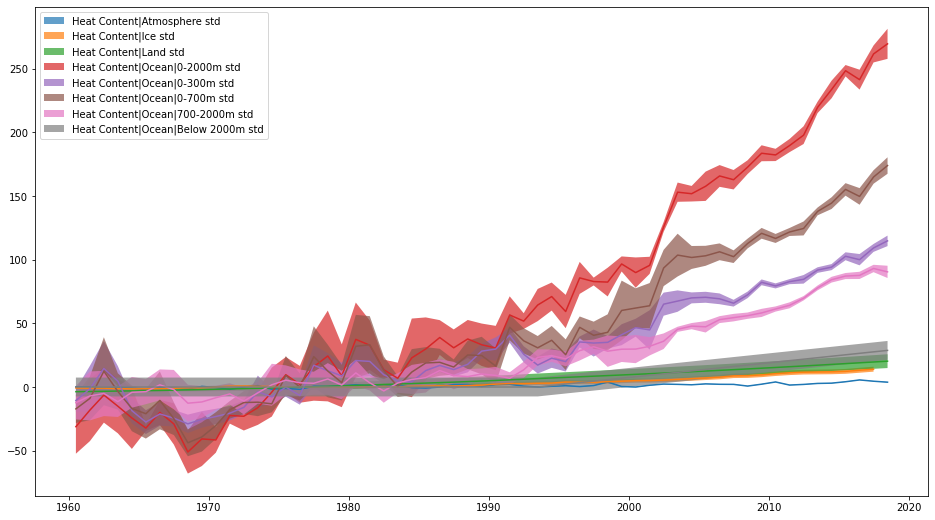

<IPython.core.display.Javascript object>

In [23]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

helper = db_spread.timeseries()
for variable, df in helper.groupby("variable"):
    std_vals = helper.loc[
        helper.index.get_level_values("variable") == variable, :
    ].values.squeeze()

    central = db.filter(variable=variable.replace(" std", "")).values.squeeze()
    ax.plot(
        df.columns.values.squeeze(),
        central,
        #         label=variable,
    )
    ax.fill_between(
        df.columns.values.squeeze(),
        central - std_vals,
        central + std_vals,
        label=variable,
        alpha=0.7,
    )

ax.legend()

In [24]:
unused = [
    v
    for v in db["variable"]
    if v not in protocol_variables["Variable"].tolist() and not v.endswith("std")
]
assert not unused, unused

<IPython.core.display.Javascript object>

In [25]:
db.to_nc(OUTPUT_FILE, dimensions=("region",))
OUTPUT_FILE

'../../data/interim/vonschuckmann_2020/vonschuckmann_2020_rcmip.nc'

<IPython.core.display.Javascript object>

## Create assessed ranges

In [26]:
start_yr = 1971
end_yr = 2018
unit = "ZJ"

<IPython.core.display.Javascript object>

In [27]:
def get_value(db, variable, year=end_yr, ref_year=start_yr):
    out = db.filter(variable=variable)
    if ref_year is not None:
        out = out.relative_to_ref_period_mean(year=[ref_year])

    unit = out.get_unique_meta("unit", no_duplicates=True)
    assert unit == unit

    return out.filter(year=year).values.squeeze()

<IPython.core.display.Javascript object>

In [28]:
central = get_value(db, "Heat Content|Ocean|0-2000m") + get_value(
    db, "Heat Content|Ocean|Below 2000m"
)
central

320.69251537323

<IPython.core.display.Javascript object>

In [29]:
db_spread.filter(variable="Heat Content|Ocean|0-2000m std").head()

time                                                                                                                                                                     1960-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...   21.220945   

time                                                                                                                                                                     1961-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...   24.370842   

time                                                                                                                                                                     1962-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...   21.673958   

time                                                                                                                                                                     1963-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...    21.27743   

time                                                                                                                                                                     1964-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...   24.300568   

time                                                                                                                                                                     1965-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...    2.275124   

time                                                                                                                                                                     1966-06-30  \
model          region scenario   source                  unit variable                       variable_source_name    variable_standard_name                                           
not_applicable World  historical vonshuckmann_et_al_2020 ZJ   Heat Content|Ocean|0-2000m std ohc_0-2000m_uncertainty Ensemble Standard Deviation of Area Averaged Oc...    9.790393   

time                                                                                                                                                  

<IPython.core.display.Javascript object>

In [30]:
# assume uncorrelated errors and consider errors at both start and end of interval
std = (
    get_value(db_spread, "Heat Content|Ocean|0-2000m std", ref_year=None) ** 2
    + get_value(
        db_spread, "Heat Content|Ocean|0-2000m std", year=start_yr, ref_year=None
    )
    ** 2
    + get_value(db_spread, "Heat Content|Ocean|Below 2000m std", ref_year=None) ** 2
    + get_value(
        db_spread, "Heat Content|Ocean|Below 2000m std", year=start_yr, ref_year=None
    )
    ** 2
) ** 0.5
std

17.020343912051214

<IPython.core.display.Javascript object>

In [31]:
assessed_range = utils.rcmip.make_ar(
    "Heat Content|Ocean World ssp245 {}-{}".format(start_yr, end_yr),
    "Heat Content|Ocean",
    "World",
    "ssp245",
    end_yr,
    end_yr,
    start_yr,
    start_yr,
    "",
    central - std,
    central,
    central + std,
    "",
    unit,
    "mean",
    "Von Schuckmann et al. 2020",
)
assessed_range.to_csv(OUTPUT_FILE_ARS, index=False)
assessed_range

RCMIP name      RCMIP variable RCMIP region  \
0  Heat Content|Ocean World ssp245 1971-2018  Heat Content|Ocean        World   

  RCMIP scenario  evaluation_period_start  evaluation_period_end  \
0         ssp245                     2018                   2018   

   norm_period_start  norm_period_end very_likely__lower  likely__lower  \
0               1971             1971                        303.672171   

      central  likely__upper very_likely__upper unit RCMIP evaluation method  \
0  320.692515     337.712859                      ZJ                    mean   

                       Source  
0  Von Schuckmann et al. 2020

<IPython.core.display.Javascript object>